In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos.supervised import SupervisedEngine

from common.models import resnet, deeplab
from common import metrics
from common.models.modutils import load_model


# Hyperparameters

In [14]:
log_dir = "./final/baseline"

horizon = 1024
stride = 512

batch_size = 16

num_epochs = 10

learning_rate = 1e-4

weight_decay = 1e-1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]


In [6]:
train_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride),
    batch_size,
    shuffle=False,
)


# Model

In [15]:
model = deeplab.DeepLabNet(
    resnet.ResNetFeatures(
        resnet.Bottleneck,
        resnet.RESNET50_LAYERS,
        num_features=data.NUM_FEATURES,
        return_layers=[resnet.LAYER_1, resnet.LAYER_4],
        replace_stride_with_dilation=[False, True, True],
    ),
    backbone_channels=[256, 2048],
    out_feats=1,
)

optim = AdamW(model.head.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine_supervised = SupervisedEngine(
    model, device, optimizer=optim, lr_scheduler=lr_sched
)


# Training

In [16]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine_supervised,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


Epoch 0 - train_loss = 0.183 - test_loss=0.185 - cost = 0.161 - threshold = -1.173 - lr = 1.00e-04


Epoch 1 - train_loss = 0.137 - test_loss=0.153 - cost = 0.152 - threshold = -1.618 - lr = 9.76e-05


Epoch 2 - train_loss = 0.143 - test_loss=0.155 - cost = 0.146 - threshold = -1.619 - lr = 9.05e-05


Epoch 3 - train_loss = 0.100 - test_loss=0.174 - cost = 0.150 - threshold = -0.439 - lr = 7.94e-05


Epoch 4 - train_loss = 0.096 - test_loss=0.147 - cost = 0.131 - threshold = -2.151 - lr = 6.55e-05


Epoch 5 - train_loss = 0.142 - test_loss=0.144 - cost = 0.128 - threshold = -2.037 - lr = 5.00e-05


Epoch 6 - train_loss = 0.096 - test_loss=0.145 - cost = 0.118 - threshold = -2.025 - lr = 3.45e-05


Epoch 7 - train_loss = 0.084 - test_loss=0.142 - cost = 0.116 - threshold = -1.813 - lr = 2.06e-05


Epoch 8 - train_loss = 0.102 - test_loss=0.139 - cost = 0.118 - threshold = -1.975 - lr = 9.55e-06


Epoch 9 - train_loss = 0.103 - test_loss=0.142 - cost = 0.115 - threshold = -2.039 - lr = 2.45e-06


# Evaluating

In [17]:
load_model(model, log_dir + "/models/model_9.pth", device);

In [18]:
# Cost model
cmodel = metrics.default_cmodel()


In [19]:
scores, labels = get_predictions(engine_supervised.predict, test_loader)


100%|██████████| 41/41 [00:08<00:00,  5.10it/s]


In [20]:
cmodel.fit(scores, labels).optimize()


(-2.039083747863774, 0.11503966)

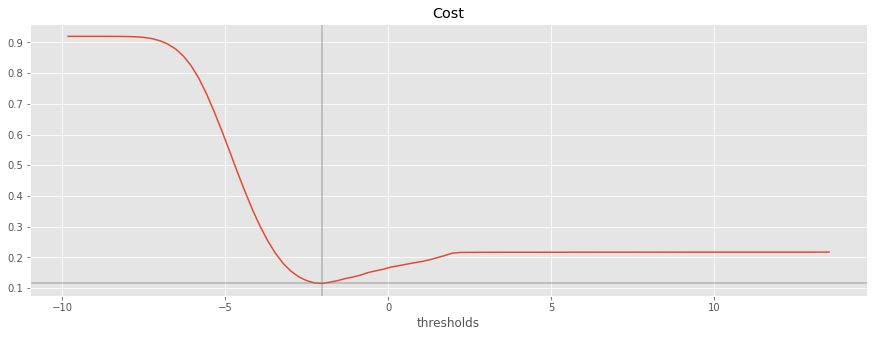

In [21]:
metrics.plot_cost(cmodel)


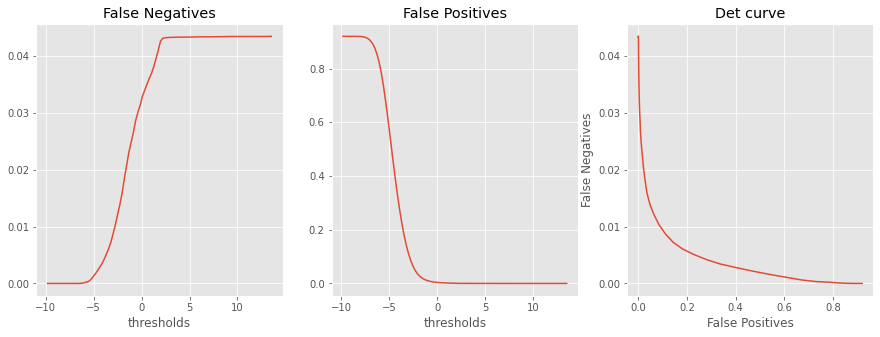

In [22]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


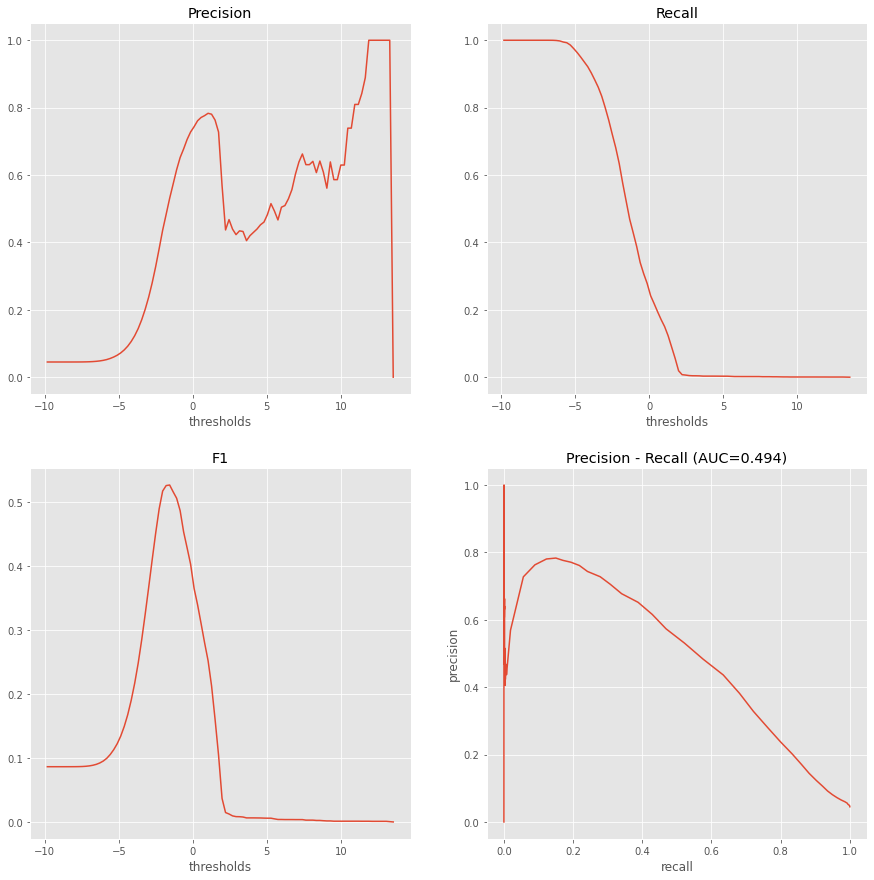

In [23]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)
